# Brain Stroke Dataset - Analysis, Part IV

**Author:** Jakub Bednarz

**Previous parts**: [Part I](https://github.com/mim-uw/eXplainableMachineLearning-2023/blob/main/Homeworks/HW1/JakubBednarz/Analysis.ipynb), [Part II](https://htmlpreview.github.io/?https://github.com/mim-uw/eXplainableMachineLearning-2023/blob/main/Homeworks/HW2/JakubBednarz/Analysis%2C%20Part%20II.html), [Part III](https://htmlpreview.github.io/?https://github.com/mim-uw/eXplainableMachineLearning-2023/blob/main/Homeworks/HW3/JakubBednarz/Analysis%2C%20Part%20III.html).

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Union
import plotly
import plotly.offline as py
import plotly.io as pio
from scipy.special import logit
from copy import deepcopy
import warnings
warnings.filterwarnings(action="ignore")
pio.renderers.default = "jpeg"
# plotly.offline.init_notebook_mode(connected=False)

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.base import BaseEstimator, ClassifierMixin
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight

import optuna
from optuna.trial import Trial, FrozenTrial
from optuna.integration.sklearn import OptunaSearchCV

import shap
import shap.maskers
import dalex
import lime

In [34]:
df = pd.read_csv("brain_stroke.csv")
for col in ("hypertension", "heart_disease"):
    df[col] = df[col].apply(lambda idx: ["No", "Yes"][idx])

In [35]:
# for name, values in df.select_dtypes("object").iteritems():
#     print(name, values.unique())

In [36]:
class ColumnTransformerEx(ColumnTransformer):
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return pd.DataFrame(
                data=np.asarray(super().transform(X)),
                columns=self.get_feature_names_out(),
                index=X.index,
            )
        else:
            return super().transform(X)
    
    def fit_transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            return pd.DataFrame(
                data=np.asarray(super().fit_transform(X, y)),
                columns=self.get_feature_names_out(),
                index=X.index,
            )
        else:
            return super().fit_transform(X, y)

cat_features = [
    "gender",
    "ever_married",
    "work_type",
    "Residence_type",
    "smoking_status",
    "hypertension",
    "heart_disease",
]

one_tf = ColumnTransformerEx(
    transformers=[
        (col, OneHotEncoder(drop="if_binary"), [col])
        for col in cat_features],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

ord_tf = ColumnTransformerEx(
    transformers=[
        (col, OrdinalEncoder(), [col])
        for col in cat_features],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

one_df = one_tf.fit_transform(df)
ord_df = ord_tf.fit_transform(df)

all_features = ord_df.columns.tolist()

cat_idxes = [all_features.index(feat) for feat in cat_features]

cat_names = {
    idx: OrdinalEncoder().fit(df[[feat]]).categories_[0]
    for idx, feat in zip(cat_idxes, cat_features)
}

X_tf = ColumnTransformerEx(
    transformers=[
        (col, OneHotEncoder(drop="if_binary"), [col])
        for col in cat_features],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

In [37]:
def split(df):
    X, y = df.drop(columns=["stroke"]), df["stroke"]
    train_X, test_X, train_y, test_y = \
        train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return train_X, test_X, train_y, test_y

train_X, test_X, train_y, test_y = split(df)
X_tf = X_tf.fit(train_X)
train_X_one, test_X_one, train_y_one, test_y_one = split(one_df)
train_X_ord, test_X_ord, train_y_ord, test_y_ord = split(ord_df)

In [38]:
conv_tf = ColumnTransformer(
    transformers=[
        (col, OneHotEncoder(drop="if_binary"), [idx])
        for col, idx in zip(cat_features, cat_idxes)],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

conv_tf = conv_tf.fit(ord_df.drop(columns=["stroke"]).to_numpy())

In [39]:
class OptunaTrainer:
    def fit(self, X, y):
        def model_fn(trial: Union[Trial, FrozenTrial]):
            return XGBClassifier(
                max_depth=int(trial.suggest_float("max_depth", 3, 18, step=1)),
                gamma=trial.suggest_float("gamma", 1, 9),
                reg_alpha=int(trial.suggest_float("reg_alpha", 40, 180, step=1)),
                reg_lambda=trial.suggest_float("reg_lambda", 0, 1),
                colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1),
                min_child_weight=int(trial.suggest_float("min_child_weight", 0, 10, step=1)),
                n_estimators=180,
                seed=42,
            )

        sample_wt = compute_sample_weight(
            class_weight="balanced",
            y=y,
        )
        
        fit_params = dict(
            sample_weight=sample_wt,
        )

        def objective(trial: optuna.Trial):
            model = model_fn(trial)
            return np.min(cross_val_score(model, X, y, scoring="roc_auc", fit_params=fit_params))
        
        optuna.logging.set_verbosity(optuna.logging.WARN)
        sampler = optuna.samplers.TPESampler(seed=99)
        study = optuna.create_study(direction="maximize", sampler=sampler)
        study.optimize(objective, n_trials=16)

        model = model_fn(study.best_trial)
        model.fit(X, y, **fit_params)
        return model

xgb_model = OptunaTrainer().fit(train_X_one, train_y_one)

In [40]:
# roc_auc_score(test_y, xgb_model.predict(test_X))

In [41]:
lr_model_cv = LogisticRegressionCV(
    solver="liblinear",
    scoring="roc_auc",
    class_weight="balanced",
)

lr_model_cv = lr_model_cv.fit(train_X_one, train_y_one)

lr_model = LogisticRegression(
    solver="liblinear",
    class_weight="balanced",
    C=lr_model_cv.C_[0],
)

lr_model = lr_model.fit(train_X_one, train_y_one)

## Introduction

In this report, having looked at the explanations given by SHAP and LIME, we will now focus on a number of other methods: *Ceteris Paribus* (CP), *Partial Dependence Profiles* (PDP) and variants such as *Accumulated Local Effects* (ALE). The goal is to gain some intuition of the results they yield by computing the variable attributions by hand for a simple example, and evaluating them for a real-world dataset.

## Toy example

We will compute PDP for a following model: $$f(x_1, x_2) = (x_1 + x_2)^2$$, where $x_1, x_2 \sim \mathcal{U}[-1, 1]$ and $x_1 = x_2$. From the definition of the PD profile for $x_1$, $$g_{PD}^{x_1}(t) = E_{x_2}[f(x_1, x_2) \mid x_1 = t] = E_{x_2 \sim \mathcal{U}[-1, 1]}[(t + x_2)^2] = t^2 + 1/3$$, since $E(X) = 0, E(X^2) = 1/3$ for $X \sim \mathcal{U}[-1, 1]$, and the same holds for $x_2$ since they're interchangeable.

## Practical examples

Let's now look at the Ceteris Paribus and Partial Dependency profiles in a real-world dataset case. As before, we shall target the brain stroke dataset. First, let's pick an observation and see how the predictions of our model change when we vary the `bmi` variable in some range.

In [42]:
gen = np.random.default_rng(seed=0)
idxes = gen.choice(len(test_X), size=2)
obs = test_X.iloc[idxes]
pd.concat([test_X, test_y], axis="columns").iloc[idxes].T

,4379,2473
gender,Male,Male
age,31.0,66.0
hypertension,No,Yes
heart_disease,No,No
ever_married,No,Yes
work_type,Self-employed,Private
Residence_type,Rural,Urban
avg_glucose_level,64.85,82.91
bmi,23.0,28.9
smoking_status,Unknown,formerly smoked


In [43]:
from typing import Dict
from numpy.typing import ArrayLike

def ceteris_paribus(model, x: pd.Series, var_name: str, values: ArrayLike):
    X = pd.DataFrame(x).T
    n = len(values)
    X = X.loc[X.index.repeat(n)].reset_index(drop=True)
    X[var_name] = values
    X = X_tf.transform(X)
    return model.predict_proba(X.values)[:,-1]

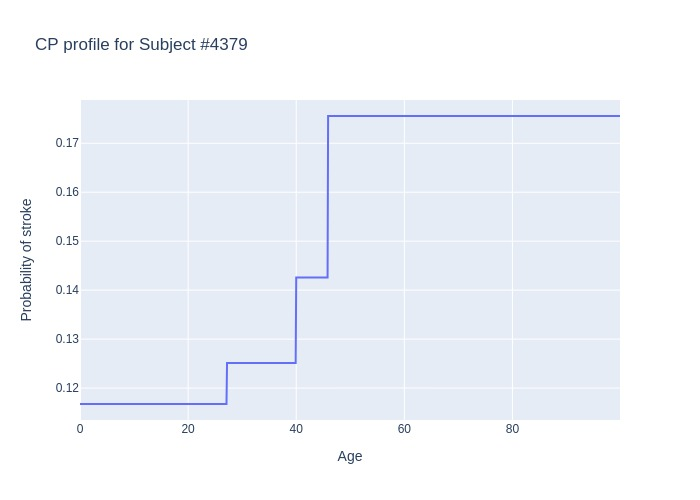

In [44]:
import plotly.graph_objects as go

values = np.arange(0.0, 100.0, 0.1)
probs = ceteris_paribus(xgb_model, obs.iloc[0], "bmi", values)

fig = go.Figure()
fig.add_trace(go.Scatter(x=values, y=probs, mode="lines"))
fig.update_layout(title=f"CP profile for Subject #{obs.index[0]}")
fig.update_xaxes(title="Age")
fig.update_yaxes(title="Probability of stroke")

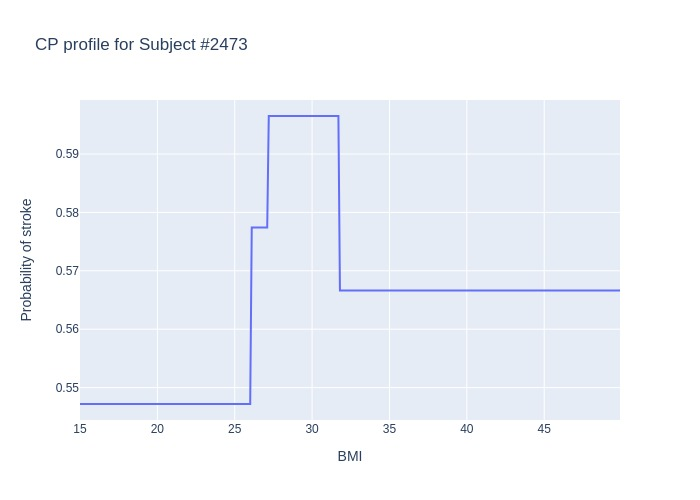

In [45]:
import plotly.graph_objects as go

values = np.arange(15.0, 50.0, 0.1)
probs = ceteris_paribus(xgb_model, obs.iloc[1], "bmi", values)

fig = go.Figure()
fig.add_trace(go.Scatter(x=values, y=probs, mode="lines"))
fig.update_layout(title=f"CP profile for Subject #{obs.index[1]}")
fig.update_xaxes(title="BMI")
fig.update_yaxes(title="Probability of stroke")

As we can see, we get the result that, when other variables are fixed, increasing BMI increases the probability of stroke for the first subject. Curiously, our model predicts that, for the second subject, the expected probability of a stroke *decreases* from a certain point onwards (right around $BMI > 31.8$). This is an example of a behavior which we wouldn't know of if we only looked at SHAP and LIME values - in this case, one possible conclusion would be that our model does something quite weird, which would be useful to know if we wished to deploy it.

So far we've look at Ceteris Paribus profiles. Insofar as they describe the effect of varying a variable for a given data point, we may ask what happens if we do that for *all* data points and average out the results - then, we will get the average effect of varying a variable, as evaluated on the entire data distribution. Such profiles are called *Partial Dependency Profiles* (PDPs). To get an intuition for how it works, let's look at the PDP for `bmi` variable:

In [46]:
def partial_dependency_profile(model, X: pd.DataFrame, var_name: str, values: ArrayLike) -> np.ndarray:
    avg_preds = []
    tmp_X = X.copy()
    for value in values:
        tmp_X[var_name] = value
        preds = model.predict_proba(X_tf.transform(tmp_X).values)[:,-1]
        avg_preds.append(np.mean(preds))
    return np.array(avg_preds)

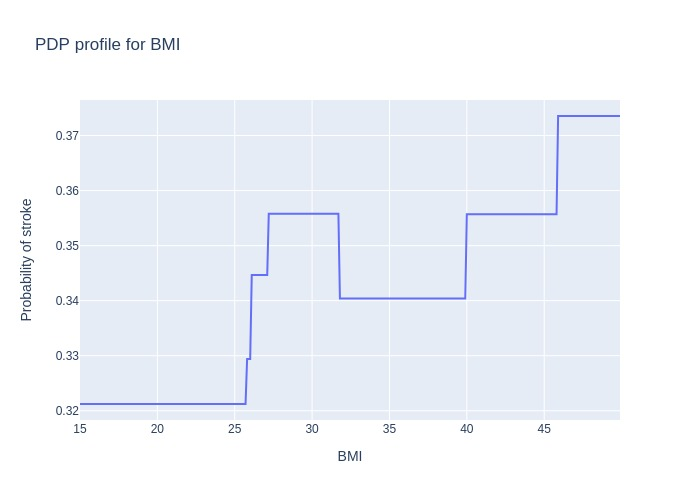

In [47]:
values = np.arange(15.0, 50.0, 0.1)
probs = partial_dependency_profile(xgb_model, test_X, "bmi", values)

fig = go.Figure()
fig.add_trace(go.Scatter(x=values, y=probs, mode="lines"))
fig.update_layout(title=f"PDP profile for BMI")
fig.update_xaxes(title="BMI")
fig.update_yaxes(title="Probability of stroke")

What we can see is that, averaged over the entire (test) dataset, the predictions of our model are quite nontrivial - in general, we can say that there is an upward trajectory, as the BMI increases, but it's not monotonic, in that at some points the average predicted probability of a stroke decreases with increasing BMI. As noted previously, such a behavior seems intuitively quite strange. Thus, PDP profiles can certainly prove to be a useful tool in diagnosing and explaining our predictive models.

Another thing we can use PDP profiles for is comparing various models. Let's do it for a tree-based model and a logistic regression model:

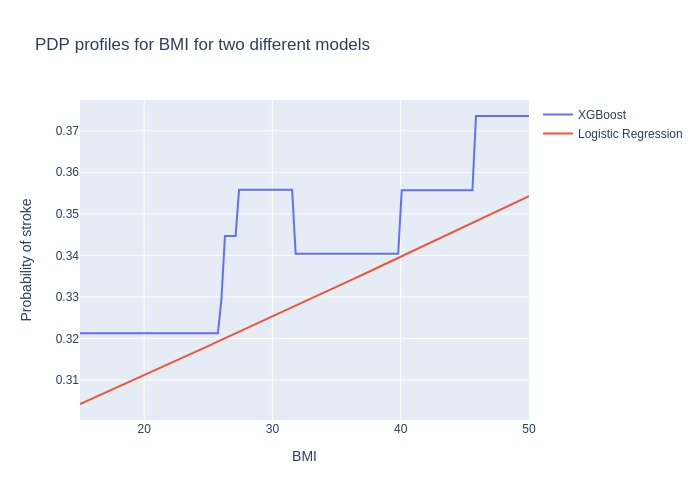

In [48]:
values = np.linspace(15.0, 50.0, 128)
xgb_probs = partial_dependency_profile(xgb_model, test_X, "bmi", values)
lr_probs = partial_dependency_profile(lr_model, test_X, "bmi", values)

fig = go.Figure()
fig.add_trace(go.Scatter(x=values, y=xgb_probs, mode="lines", name="XGBoost"))
fig.add_trace(go.Scatter(x=values, y=lr_probs, mode="lines", name="Logistic Regression"))
fig.update_layout(title=f"PDP profiles for BMI for two different models")
fig.update_xaxes(title="BMI")
fig.update_yaxes(title="Probability of stroke")

One conclusion we can draw is that logistic regression-based model underestimates the probability, when compared to the XGBoost model. Second would be that logistic regression model better matches our intuition with regards to the expected effect of increasing subject's BMI to the probability of stroke, though one must note that the difference is not *that* massive (see the y-axis). Nevertheless, this observation could be one reason why our stakeholders would wish to choose it over the tree-based model.